In [57]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [58]:
# enrichment_file = "fgsea"
enrichment_file = "gprofiler"

if enrichment_file == "fgsea": # Get fgsea results.
    enr = pd.read_csv("/users/csb/huizing/Documents/PhD/Code/mowgli_reproducibility/enrich/fgsea.csv", index_col=0)
    enr.rename(columns={"pathway": "native", "col": "dim", "pval": "p_value"}, inplace=True)
    enr["dim"] = enr["dim"].str.replace("X", "").astype(int)
    # Acutally, it should be padj instead of pval, but nothing is significant...

elif enrichment_file == "gprofiler": # Get gprofiler results. 
    enr = pd.read_csv("/users/csb/huizing/Documents/PhD/Code/mowgli_reproducibility/enrich/enrichment.csv", index_col=0)
    enr["dim"] = enr["query"].str.split(" ", expand=True)[1].astype(int)

In [59]:
# enr = enr[enr["source"] == "GO:MF"] # Molecular function
# enr = enr[enr["source"] == "GO:CC"] # Cellular component
enr = enr[enr["source"] == "GO:BP"] # Biological process
# enr = enr[enr["source"] == "KEGG"] # KEGG pathways
# enr = enr[enr["source"] == "REAC"] # Reactome pathways

In [60]:
enr = enr[enr["p_value"] < .05]

In [61]:
enr["minlogp"] = -np.log10(enr["p_value"])

In [62]:
enr.head()

,source,native,name,p_value,significant,description,term_size,query_size,intersection_size,effective_domain_size,precision,recall,query,parents,method,dim,minlogp
0,GO:BP,GO:0048583,regulation of response to stimulus,1.193932e-21,True,"""Any process that modulates the frequency, rat...",3895,177,94,21100,0.531073,0.024134,mofa 9,"['GO:0050789', 'GO:0050896']",mofa,9,20.923020
1,GO:BP,GO:0030217,T cell differentiation,8.420518e-18,True,"""The process in which a precursor cell type ac...",267,178,27,21100,0.151685,0.101124,mofa 3,"['GO:0030098', 'GO:0042110']",mofa,3,17.074661
2,GO:BP,GO:0042110,T cell activation,1.714372e-17,True,"""The change in morphology and behavior of a ma...",504,178,34,21100,0.191011,0.067460,mofa 3,['GO:0046649'],mofa,3,16.765895
3,GO:BP,GO:0050896,response to stimulus,1.749457e-17,True,"""Any process that results in a change in state...",8885,177,136,21100,0.768362,0.015307,mofa 9,['GO:0008150'],mofa,9,16.757097
4,GO:BP,GO:0010646,regulation of cell communication,1.871537e-17,True,"""Any process that modulates the frequency, rat...",3336,177,81,21100,0.457627,0.024281,mofa 9,"['GO:0007154', 'GO:0050794']",mofa,9,16.727801


## Count enrichments

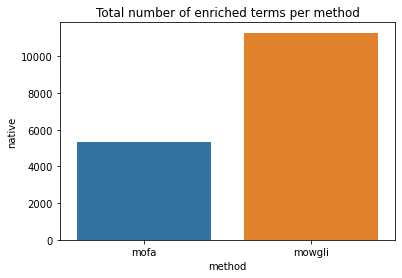

In [63]:
plt.title("Total number of enriched terms per method")
sns.barplot(data=enr.groupby("method").count().reset_index(), x="method", y="native")
plt.show()

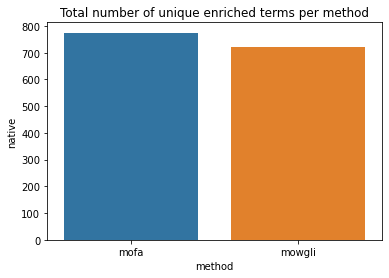

In [64]:
plt.title("Total number of unique enriched terms per method")
sns.barplot(data=enr.groupby("method")["native"].nunique().reset_index(), x="method", y="native")
plt.show()

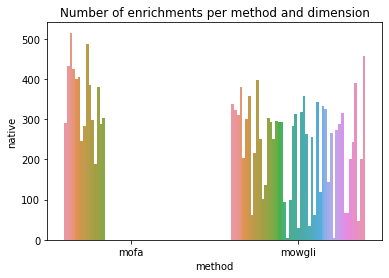

In [65]:
fig, ax = plt.subplots(1, 1)
sns.barplot(data=enr.groupby(["method", "dim"])["native"].count().reset_index(), x="method", y="native", hue="dim", ax=ax)
ax.get_legend().remove()
ax.set_title("Number of enrichments per method and dimension")
plt.show()

## Check specificity

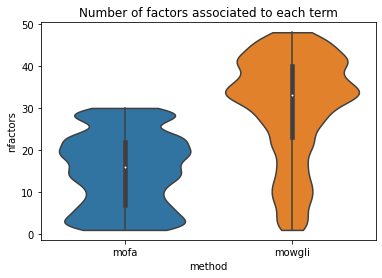

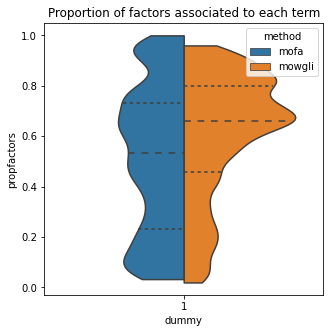

In [66]:
enr["nfactors"] = 0
nfactors = enr.groupby(["native", "method"])["native"].count()
enr.set_index(["native", "method"], inplace=True)
enr.loc[nfactors.index, "nfactors"] = nfactors
enr.reset_index(inplace=True)

plt.title("Number of factors associated to each term")
sns.violinplot(data=enr, x="method", y="nfactors", cut=0)
plt.show()

enr["ndim"] = 0
enr.loc[enr["method"] == "mofa", "ndim"] = 30
enr.loc[enr["method"] == "mowgli", "ndim"] = 50
enr["propfactors"] = enr["nfactors"] / enr["ndim"]
enr["dummy"] = 1

fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.set_title("Proportion of factors associated to each term")
sns.violinplot(
    data=enr,
    x="dummy",
    hue="method",
    y="propfactors",
    split=True,
    ax=ax,
    inner="quart",
    cut=0,
)
plt.show()


In [67]:
selectivity_mofa = (enr[enr["method"] == "mofa"]["native"].nunique() + 30) / (2*enr[enr["method"] == "mofa"]["native"].count())
selectivity_mowgli = (enr[enr["method"] == "mowgli"]["native"].nunique() + 50) / (2*enr[enr["method"] == "mowgli"]["native"].count())
print("Selectivity of MOFA+: {:.4f}".format(selectivity_mofa))
print("Selectivity of Mowgli: {:.4f}".format(selectivity_mowgli))

Selectivity of MOFA+: 0.0756
Selectivity of Mowgli: 0.0342


## Biology-driven check

In [68]:
enr.head()

,native,method,source,name,p_value,significant,description,term_size,query_size,intersection_size,...,precision,recall,query,parents,dim,minlogp,nfactors,ndim,propfactors,dummy
0,GO:0048583,mofa,GO:BP,regulation of response to stimulus,1.193932e-21,True,"""Any process that modulates the frequency, rat...",3895,177,94,...,0.531073,0.024134,mofa 9,"['GO:0050789', 'GO:0050896']",9,20.923020,29,30,0.966667,1
1,GO:0030217,mofa,GO:BP,T cell differentiation,8.420518e-18,True,"""The process in which a precursor cell type ac...",267,178,27,...,0.151685,0.101124,mofa 3,"['GO:0030098', 'GO:0042110']",3,17.074661,22,30,0.733333,1
2,GO:0042110,mofa,GO:BP,T cell activation,1.714372e-17,True,"""The change in morphology and behavior of a ma...",504,178,34,...,0.191011,0.067460,mofa 3,['GO:0046649'],3,16.765895,23,30,0.766667,1
3,GO:0050896,mofa,GO:BP,response to stimulus,1.749457e-17,True,"""Any process that results in a change in state...",8885,177,136,...,0.768362,0.015307,mofa 9,['GO:0008150'],9,16.757097,29,30,0.966667,1
4,GO:0010646,mofa,GO:BP,regulation of cell communication,1.871537e-17,True,"""Any process that modulates the frequency, rat...",3336,177,81,...,0.457627,0.024281,mofa 9,"['GO:0007154', 'GO:0050794']",9,16.727801,29,30,0.966667,1


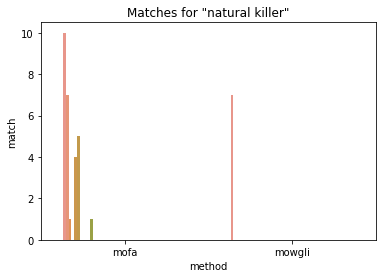

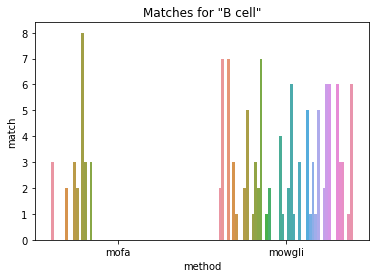

In [69]:
def barplot_matches(keywords, case=False):
    enr["match"] = enr["name"].str.contains(keywords, case=case)
    fig, ax = plt.subplots(1, 1)
    sns.barplot(
        data=enr.groupby(["method", "dim"])["match"].sum().reset_index(),
        x="method",
        y="match",
        hue="dim",
        ax=ax,
    )
    ax.set_title(f'Matches for "{keywords}"')
    ax.get_legend().remove()
    plt.show()


barplot_matches("natural killer")
barplot_matches("B cell")


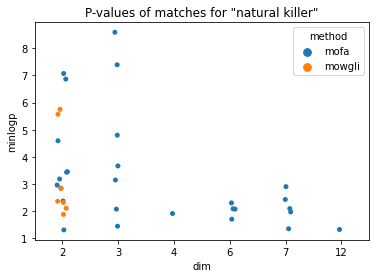

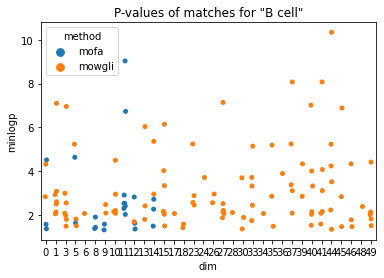

In [70]:
def stripplot_matches(keywords, case=False):
    fig, ax = plt.subplots(1, 1)
    sns.stripplot(
        data=enr[enr["name"].str.contains(keywords, case=case)],
        x="dim",
        y="minlogp",
        hue="method",
    )
    ax.set_title(f"P-values of matches for \"{keywords}\"")
    plt.show()

stripplot_matches("natural killer")
stripplot_matches("B cell")